In [16]:
% setup environment
% clear data and number format
clear; format short e
% set path to equilibrium solver
txt=pwd; n=length(txt); rootpath=txt;
n=strfind(rootpath,"USERS"); rootpath=txt(1:n-2);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB'];
addpath(JEQUILIBpath);
% turn off warnings
warning off
%graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 
%graphics_toolkit("gnuplot")
% delete phreeqcrunfile
system("rm porttest.txt");

# model portlandite dissolution kinetics

follow the example [here](https://phreeqcusers.org/index.php?topic=1137.0) for calcite but replace with portlandite and the kinetic equation of the form 

$$\dfrac{d(portlandite)}{dt} = k_P X_P \left(\left(\dfrac{IAP_P}{Ksp_P}\right)-1\right)$$

portlandite.  

$$ \mathrm{Ca(OH)_2}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + 2\mathrm{OH^{-}}$$

$$K_{sp} = [\mathrm{Ca^{2+}}][\mathrm{OH^{-}}]^2=5.5e-6$$

need to use llnl database because it has portlandite in it



In [17]:
database=['llnl.dat'];

# build PHREEQC input file

follow the example [here](https://phreeqcusers.org/index.php?topic=1137.0) for calcite but replace with portlandite and the kinetic equation of the form 

$$\dfrac{d(portlandite)}{dt} = k_P X_P \left(\left(\dfrac{IAP_P}{Ksp_P}\right)-1\right)$$

portlandite.  

$$ \mathrm{Ca(OH)_2}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + 2\mathrm{OH^{-}}$$

$$K_{sp} = [\mathrm{Ca^{2+}}][\mathrm{OH^{-}}]^2=5.5e-6$$

need to use llnl database because it has portlandite in it



In [18]:
solutionboxtext=[...
{'SOLUTION 1\n'}
{'       pe      13.75\n'}
{'       pH      7\n'}
{'       temp    25\n'}
{'-units mol/kgw\n'}
   ];
[nolinesSOLN,length]=size(solutionboxtext);

In [19]:
equilibboxtext=[...
{'EQUILIBRIUM_PHASES 1\n'}
{'CO2(g)   -3.5\n'}
   ];
[nolinesEQUIL,length]=size(equilibboxtext);

In [20]:
rateboxtext=[...
{'RATES\n'}
{'Portlandite\n'}
{'-start\n'}
{'1   REM   PARM(1) = rate constant\n'}
{'10  si_pp = SI("Portlandite")\n'}
{'20  IF (M <= 0  and si_pp < 0) THEN GOTO 200\n'}
{'120 rate = PARM(1) *M* (1 - 10^(si_pp))\n'}
{'140 moles = rate*TIME\n'}
{'200 SAVE moles\n'}
{'   -end\n'}
   ];
[nolinesRATE,length]=size(rateboxtext);

In [21]:
kineticsboxtext=[...
{'KINETICS 1\n'}
{'Portlandite\n'}
{'  -tol   1e-8\n'}
{'  -m0    0.1\n'}
{'  -m     0.1\n'}
{'  -parms 1e-5  # simple rate constant\n'}
{'  -steps 0 10 20 30 40 50 60 70 80 90 100 120 140 160 s\n'}
{'  -cvode\n'}
];
[nolinesKIN,length]=size(kineticsboxtext);

In [22]:
selectboxtext=[...
{' SELECTED_OUTPUT\n'}
{' -file portout.txt\n'}
{' -selected_out true\n'}
{' -user_punch true\n'}
{' -high_precision true\n'}
{' -reset false\n'}
{' -simulation false\n'}
{' -state false\n'}
{' -distance false\n'}
{' -time false\n'}
{' -step false\n'}
{' -ph false\n'}
{' -pe false\n'}
{' -reaction false\n'}
{' -temperature false\n'}
{' -alkalinity false\n'}
{' -ionic_strength false\n'}
{' -water false\n'}
{' -charge_balance false\n'}
{' -percent_error false\n'}
%{' -molalities H+ Ca+2  \n'}
%{' -equilibrium_phases CO2(g)  \n'}
];
[nolinesSEL,length]=size(selectboxtext);

In [23]:
punchboxtext=[...
{'USER_PUNCH\n'}
{'        -headings seconds  Ca  pH  \n'}
{'  10 PUNCH SIM_TIME, TOT("Ca"), -LA("H+")\n'}
];
[nolinesPUNCH,length]=size(punchboxtext);

In [24]:
fileID=fopen('porttest.txt','w');

fprintf(fileID,'TITLE TEST PORTLANDITE DISSOLUTION\n');

for i=1:nolinesSOLN
    line=cell2mat(solutionboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesEQUIL
    line=cell2mat(equilibboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesRATE
    line=cell2mat(rateboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesKIN
    line=cell2mat(kineticsboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesSEL
    line=cell2mat(selectboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesPUNCH
    line=cell2mat(punchboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
fprintf(fileID,'END');
fclose(fileID);

In [25]:
str=['system("phreeqc porttest.txt out.txt ', database,'");'];
eval(str); % output to the screen
%evalc(str); % so no screen output
fid = fopen('portout.txt','rt');
hdr = strtrim(regexp(fgetl(fid),'\t','split'));
hdr=hdr(1:3)';
mat = cell2mat(textscan(fid,repmat('%f',1,numel(hdr))));
[nsize,msize]=size(mat);
time=mat(2:nsize,1); Caphreeqc=mat(2:nsize,2); pHphreeqc=mat(2:nsize,3);

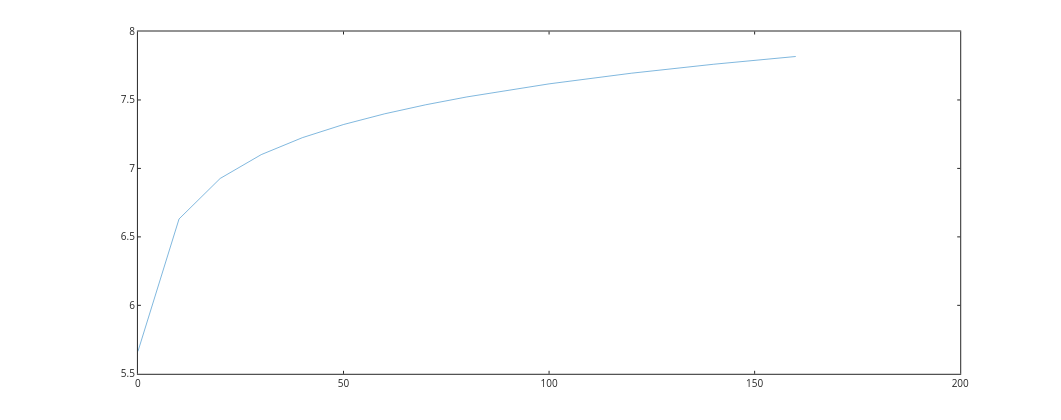

In [26]:
plot(time,pHphreeqc)

# also solve with the ODE solver

In [27]:
function [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca,Kw,KH,Ka1,Ka2,PCO2)

a=1; b=2*Ca; c=-KH*Ka1*PCO2-Kw; d=-2*KH*Ka1*Ka2*PCO2;
H=roots([a b c d]);
H=H(imag(H)==0); %sets any imaginary roots to zero
% display the positive real root
H=H(H>0);
%solve speciation
H2CO3=KH*PCO2; HCO3=(KH*PCO2*Ka1)/H; CO3=(KH*PCO2*Ka1*Ka2)/(H^2); OH=Kw/H;

end

In [28]:
% try with ode solver.  first need to define the function

function dCdt=dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspP,kP)

[H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(C(2),Kw,KH,Ka1,Ka2,PCO2);

IAPP=C(2)*OH^2; 

dCdt=zeros(2,1); % top entry is [portlandite].  bottom entry is [calcium cation].  

%rate of decrease in portlandite concentration.  IAP/Ksp is less than 1 so rate is negative
dCdt(1)=kP*C(1)*(IAPP/KspP-1);  

%rate of increase in calcium concentration from port dissolve and decrease Ca from calcite ppte
dCdt(2)=-kP*C(1)*(IAPP/KspP-1);  

dC=dCdt;

end

In [29]:
% make an anonymous function because ODE solver only wants conc and time as variables
% and dfine all the constants too

%Kw=1e-14; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; PCO2=10^-3.5; KspC=3.4e-9; KspC=1.4e-8;
%KspP=5.5e-6; kC=1e-4; kP=1e-6;

Kw=1e-14; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; PCO2=10^-3.5; KspP=5.5e-6; kP=1e-5;

dCdtrate = @(t,C)dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspP,kP);


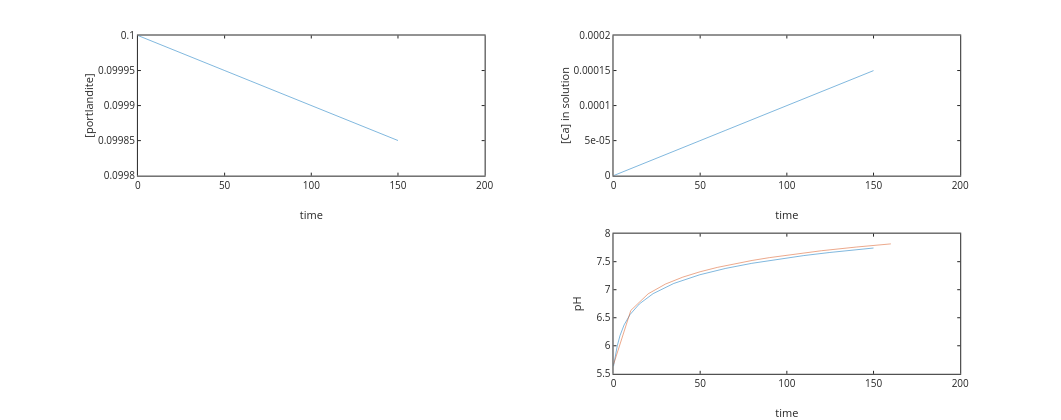

In [30]:
% call ODE solver

[t, C]=ode45(dCdtrate,[0 150],[0.1 0]); 

port=C(:,1); %portlandite left over
Ca=C(:,2); [n,m]=size(Ca);
pH=[]; % pH reset

for i=1:n
    [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca(i),Kw,KH,Ka1,Ka2,PCO2);
    pH(i)=-log10(H);
end

subplot(221); plot(t,port); ylabel('[portlandite]'); xlabel('time')
subplot(222); plot(t,Ca); ylabel('[Ca] in solution'); xlabel('time')
subplot(224); plot(t,pH,time,pHphreeqc); ylabel('pH'); xlabel('time')
